In [1]:
import os
import sqlite3
import pandas as pd
import torch
import json
from transformers import RobertaTokenizer
from modules.models import CodeBertJS,CodeT5
from modules.datasets import CodeBertDataset, CodeT5Dataset
from modules.metrics import CodeRouge
from torch.utils.data import DataLoader

SQLITE_PATH = input("Paste sqlite3 path: ")
MODEL_NAME = input("Paste Model Name (CodeT5JS, CodeBertJS): ")
VERSION = int(input("Paste model version: "))
CPKT_PATH = input('Paste cpkt path: ')
METRICS_PATH = input('Paste metris dir path: ')
HF_DIR = 'Salesforce/codet5-small' if MODEL_NAME == 'CodeT5JS' else 'microsoft/codebert-base-mlm'
MAX_LENGTH = int(input("Paste tokenizer max length: "))
DB_TABLE = "commitpackft_classified_test"

with open('bug-types.json', 'r') as f:
    bugTypesDir = json.load(f)['data']
bugTypes = [row['type'] for row in bugTypesDir]
bugTypesStr = ", ".join(bugTypes)

BUG_TYPE = CPKT_PATH.split('_')[1]
if not any(BUG_TYPE in bT for bT in bugTypes):
    raise ValueError('Invalid Bug Type')


In [2]:
if not os.path.exists(SQLITE_PATH):
    raise RuntimeError('Test Dataset not found.')
con = sqlite3.connect(SQLITE_PATH)

def get_query(bug_type: str):
    return f"SELECT * FROM {DB_TABLE} WHERE bug_type like '%{bug_type}%'"

ds_df = pd.read_sql_query(get_query(BUG_TYPE), con)
print(f"Selected Bug Type : {BUG_TYPE}\nFound {len(ds_df)} samples")

Selected Bug Type : general
Found 1281 samples


In [4]:
if MODEL_NAME == 'CodeT5JS':
    model = CodeT5.load_from_checkpoint(CPKT_PATH)
elif 'CodeBertJS' in MODEL_NAME:
    model = CodeBertJS.load_from_checkpoint(CPKT_PATH)
    
if model.device != 'cpu':
    model.to('cpu')

model.mode = 'test'

/home/disras/miniconda3/envs/thesis/lib/python3.8/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.2.1


In [5]:
tokenizer = RobertaTokenizer.from_pretrained(HF_DIR)
encoded_samples = tokenizer(
    ds_df['old_contents'].tolist(),
    max_length=MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='pt',
)

encoded_labels = tokenizer(
    ds_df['new_contents'].tolist(),
    max_length=MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='pt',
)

In [11]:
if MODEL_NAME == 'CodeT5JS':
    torch_ds = CodeT5Dataset(encodings=encoded_samples, decodings=encoded_labels)
elif 'CodeBertJS' in MODEL_NAME:
    torch_ds = CodeBertDataset(encoded_samples, encoded_labels.input_ids)
loader = DataLoader(torch_ds, batch_size=1)


from tqdm import tqdm
generated_codes = []
for batch in tqdm(iter(loader), desc="Processing Batches"):
    if MODEL_NAME == 'CodeT5JS':
        print(batch.keys())
        raise ValueError
        out = model.forward(batch)
    elif 'CodeBertJS' in MODEL_NAME:
        out = model.forward(**batch)
    decoded_out = torch.argmax(out[1], dim=-1)
    generated_codes.append(tokenizer.batch_decode(decoded_out, skip_special_tokens=True)[0])
    
references = ds_df['new_contents'].tolist()

if(len(generated_codes) != len(references)):
    raise ValueError("Invalid model output.")

Processing Batches:   0%|          | 0/1281 [00:00<?, ?it/s]

{'input_ids': tensor([[    0, 10806, 48415,  5457,  2703, 45803,  6504,  4450,  2650,    12,
         17884, 27645, 50118, 50118, 10806, 17149,   597,  1215,   574, 46219,
          5457,  4430,  1009, 46959, 50118, 10806, 18134, 43637,  5457,    92,
         44314,  1640, 19159,   597,  1215,   574, 46219,    43, 50118, 50118,
         35435,  5375,  9966, 41342,    36, 45692,  9966,     6, 15357,  9966,
             6,  1735,    43, 25522, 50118,  1437, 15747,  3741,  2413,  1943,
          5457,  1735,     4,  3998,  2413,  1943, 50118,  1437, 15747,  8415,
         23031,   990,  9782,  5457,  1735,     4, 13529, 14477, 23031,   990,
          9782, 50140,  1437,   114,    36, 17884,     4,  3463,  1952, 41342,
          1640, 31549,  9966, 35122, 25522, 50118,  1437,  1437,  1437,   114,
            36,  3998,  2413,  1943,    43, 25522, 50118,  1437,  1437,  1437,
          1437,  1437, 48415,     4,   611, 14377, 41342,  1640, 31549,  9966,
             6, 43756, 22886, 45803, 3

ValueError: 

In [9]:
rouge = CodeRouge(['rouge7','rouge8','rouge9','rougeL','rougeLsum'])

rouge.compute(predictions=generated_codes, references=references)
rouge.calc_averages()

avgs_path = f"{METRICS_PATH}/{MODEL_NAME}_{VERSION}.json"
all_path = f"{METRICS_PATH}/{MODEL_NAME}_{VERSION}.csv"
with open(avgs_path, 'w') as f:
    json.dump(rouge.avgs, f)

all_scores = []
for r in rouge.rouge_types:
    all_scores += rouge.rouge_type_to_list(r)

metrics_df = pd.DataFrame(all_scores)

for m in ['precision','recall','fmeasure']:
    metrics_df[m] = round(metrics_df[m], 3)
metrics_df.to_csv(all_path, index='table')

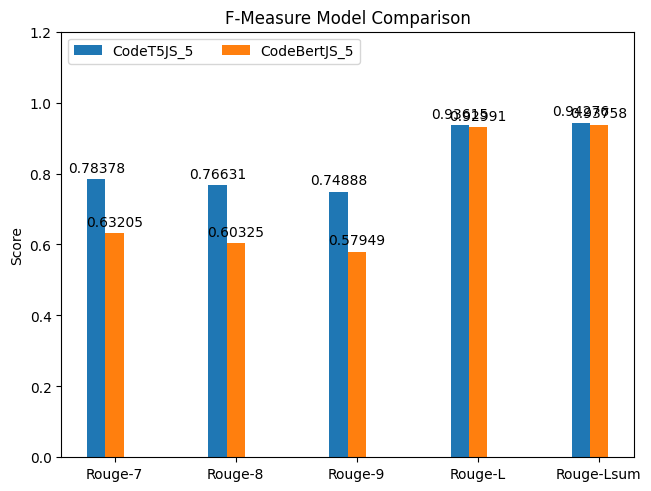

In [11]:
import json
import matplotlib.pyplot as plt
import numpy as np

codebert_avgs = rouge.avgs

comparison_model_path = input('Comparison model avg ROUGE-N metrics path: ')
comparison_model = comparison_model_path.split('/')[-1].split('.')[0]
if not os.path.exists(comparison_model_path):
    raise RuntimeError('Metrics path does not exist.')

with open(comparison_model_path, 'r') as f:
    codet5_avgs = json.load(f)
    

plot_data = {
    f"{MODEL_NAME}_{VERSION}": (round(codebert_avgs['avg_rouge7'].fmeasure, 5), round(codebert_avgs['avg_rouge8'].fmeasure, 5), round(codebert_avgs['avg_rouge9'].fmeasure, 5), round(codebert_avgs['avg_rougeL'].fmeasure, 5), round(codebert_avgs['avg_rougeLsum'].fmeasure, 5)),
    comparison_model: (round(codet5_avgs['avg_rouge7'][2], 5), round(codet5_avgs['avg_rouge8'][2], 5), round(codet5_avgs['avg_rouge9'][2], 5), round(codet5_avgs['avg_rougeL'][2], 5), round(codet5_avgs['avg_rougeLsum'][2], 5)),
}

metric_types = ('Rouge-7', 'Rouge-8','Rouge-9', 'Rouge-L', 'Rouge-Lsum')
x = np.arange(len(metric_types))
width = 0.15
multiplier = 0

fix, ax = plt.subplots(layout='constrained')


for model, values in plot_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, values, width, label=model)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Score')
ax.set_title('F-Measure Model Comparison')
ax.set_xticks(x + width, metric_types)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 1.2)

plt.savefig(f"{METRICS_PATH}/{MODEL_NAME}_{VERSION}_vs_{comparison_model}.png", dpi=300, bbox_inches='tight')
plt.show()

<Axes: title={'center': 'F-Measure Model Comparison'}, ylabel='Score'>

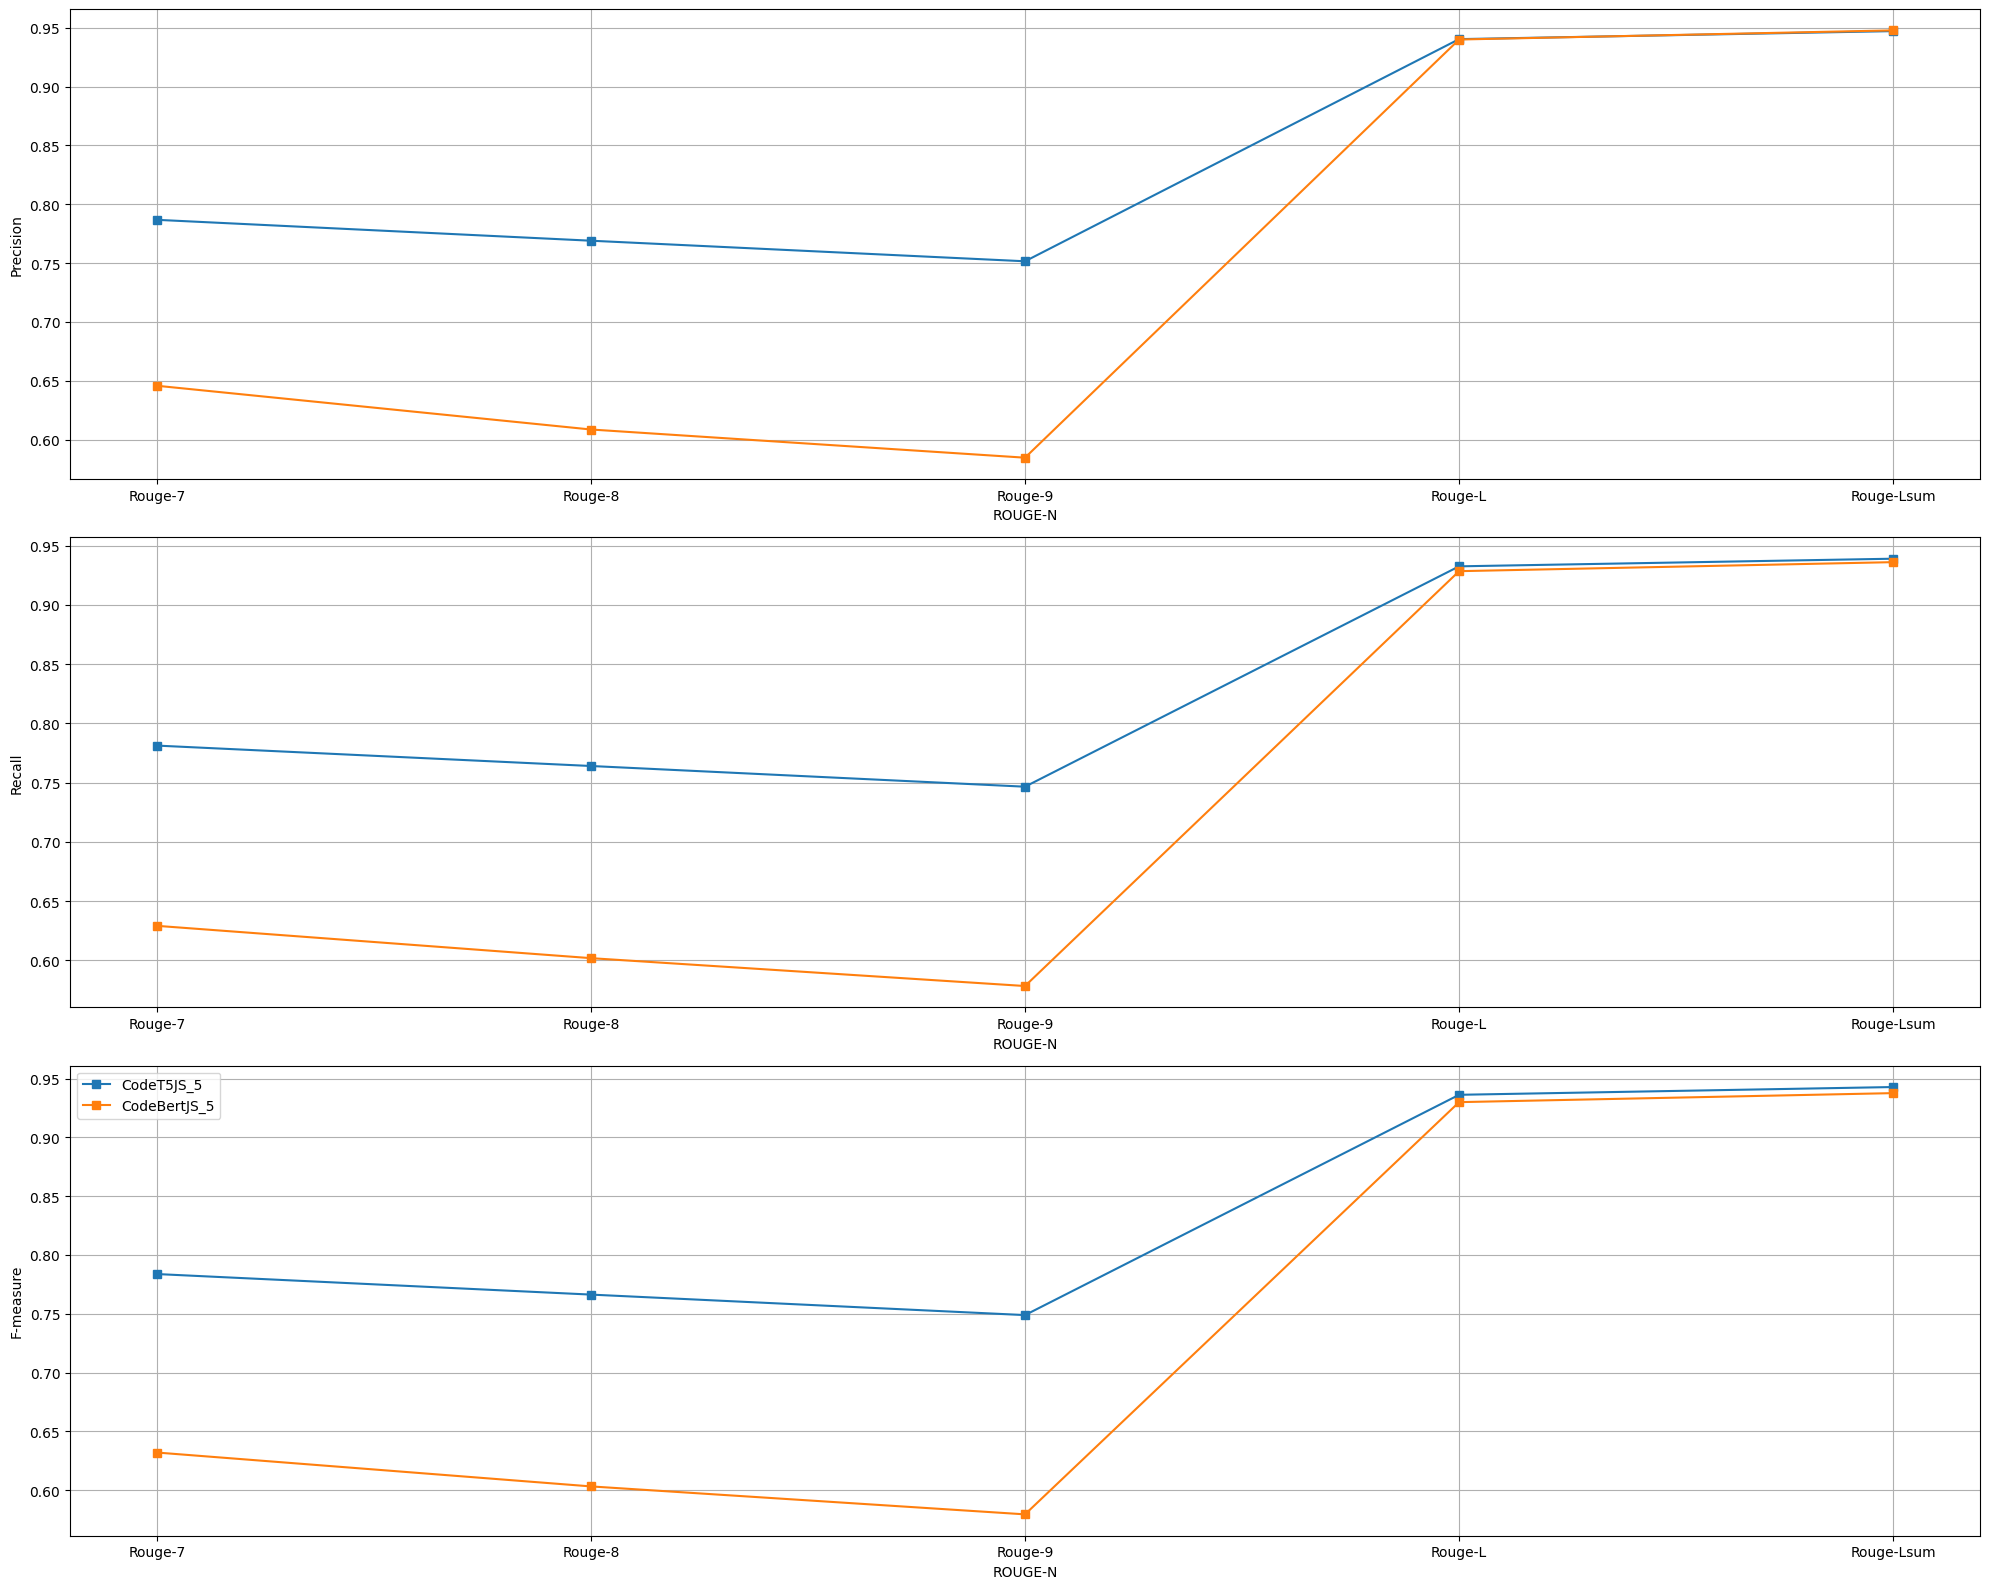

In [12]:
import json
import matplotlib.pyplot as plt
import numpy as np

codebert_avgs = rouge.avgs  # Assuming rouge is a library/function that provides average scores

comparison_model_path = input('Comparison model avg ROUGE-N metrics path: ')
comparison_model = comparison_model_path.split('/')[-1].split('.')[0]
if not os.path.exists(comparison_model_path):
    raise RuntimeError('Metrics path does not exist.')

with open(comparison_model_path, 'r') as f:
    codet5_avgs = json.load(f)

# Define metric types (assuming same metrics for both models)
metric_types = ('Rouge-7', 'Rouge-8', 'Rouge-9', 'Rouge-L', 'Rouge-Lsum')

# Create a figure with 3 rows (subplots) and 1 column
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 16))

# Data dictionaries for each metric (assuming data structure from rouge)
precision_data = {
    f"{MODEL_NAME}_{VERSION}": (codebert_avgs['avg_rouge7'].precision, codebert_avgs['avg_rouge8'].precision, codebert_avgs['avg_rouge9'].precision, codebert_avgs['avg_rougeL'].precision, codebert_avgs['avg_rougeLsum'].precision),
    comparison_model: (codet5_avgs['avg_rouge7'][0], codet5_avgs['avg_rouge8'][0], codet5_avgs['avg_rouge9'][0], codet5_avgs['avg_rougeL'][0], codet5_avgs['avg_rougeLsum'][0]),
}
recall_data = {
    f"{MODEL_NAME}_{VERSION}": (codebert_avgs['avg_rouge7'].recall, codebert_avgs['avg_rouge8'].recall, codebert_avgs['avg_rouge9'].recall, codebert_avgs['avg_rougeL'].recall, codebert_avgs['avg_rougeLsum'].recall),
    comparison_model: (codet5_avgs['avg_rouge7'][1], codet5_avgs['avg_rouge8'][1], codet5_avgs['avg_rouge9'][1], codet5_avgs['avg_rougeL'][1], codet5_avgs['avg_rougeLsum'][1]),
}
f1_data = {
    f"{MODEL_NAME}_{VERSION}": (codebert_avgs['avg_rouge7'].fmeasure, codebert_avgs['avg_rouge8'].fmeasure, codebert_avgs['avg_rouge9'].fmeasure, codebert_avgs['avg_rougeL'].fmeasure, codebert_avgs['avg_rougeLsum'].fmeasure),
    comparison_model: (round(codet5_avgs['avg_rouge7'][2], 5), round(codet5_avgs['avg_rouge8'][2], 5), round(codet5_avgs['avg_rouge9'][2], 5), round(codet5_avgs['avg_rougeL'][2], 5), round(codet5_avgs['avg_rougeLsum'][2], 5)),
}


# Plot Precision (ax1)
for model, precision in precision_data.items():
    ax1.plot(metric_types, precision, label=model, marker='s')  # 's' for square marker
ax1.set_xlabel('ROUGE-N')
ax1.set_ylabel('Precision')
ax1.grid(True)

# Plot Recall (ax2)
for model, recall in recall_data.items():
    ax2.plot(metric_types, recall, label=model, marker='s')  # 'o' for circle marker
ax2.set_xlabel('ROUGE-N')
ax2.set_ylabel('Recall')
ax2.grid(True)

# Plot F1 Score (ax3)
for model, f1 in f1_data.items():
    ax3.plot(metric_types, f1, label=model, marker='s')
ax3.set_xlabel('ROUGE-N')
ax3.set_ylabel('F-measure')
ax3.grid(True)

plt.legend(loc='upper left')
plt.tight_layout()

# Save the entire figure as a single PNG
plt.savefig(f"{METRICS_PATH}/{MODEL_NAME}_{VERSION}_vs_{comparison_model}.png", dpi=300, bbox_inches='tight')
ax